# Introduction

Welcome to Fredernick Lindemeyer's Project! Our focus revolves around implementing exploratory techniques of the models used to classify the brain waves -- we're identifying the "sentimental" explanation of the predictions that models make, which are often are obscured by the complex and near impossible to understand math.

We decided to focus on nicotine consumption based on several factors:
* Theres been research conducted in the impact of nicotine on brain waves already and there is common consensus in the increase in alpha waves

In general, we hypothesize an increase in alpha waves when Frederick, smokes with his vape. We plan on using two models, the EEGNet architecture which examplifies a black box model, and a basic logistic regression classifier, which corresponds to an interpretable model.

# Data Collection and Cleaning

Our data, much like our lives during quarantine, has no control. It was haphazardly collected from a Muse (the first one it think) headband by Frederick with him recording times when he succumbs to devil's temptations and takes a hit. There are four sessions total with each session having their own external factors (e.g. time of day, the accelormeter, amount of nicotine taken in, etc.) that we will not be taking into account; however, each session has a period of sobriety and intoxication from the nicotine that should contain signals.


### Muse information

The Muse's sampling rate is >240Hz. Since alpha waves occilate around 8-12 Hz, this well satisfies the Nyquist Theorem. Muse allows four different types of return values: absolute power bands, raw eeg, discrete frequency, and spectrogram. The Muse also only collects data from the regions TP9, AF7, AF8, and TP10.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytorch

ModuleNotFoundError: No module named 'pytorch'

In [79]:
ses1.columns

Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7',
       'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8',
       'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10',
       'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'HeadBandOn',
       'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery', 'Elements'],
      dtype='object')

In [2]:
# Data File Paths
session_one_fp = "data/session_one/mindMonitor_2021-02-10--09-18-15.csv"
session_two_fp = "data/session_two/mindMonitor_2021-02-24--07-21-47.csv"
session_three_fp = "data/session_three/mindMonitor_2021-03-03--12-17-29.csv"

def moving_avg(arr:list, n:int) -> list:
    """
    returns a list of moving mean from arr with n-size batches
    """
    return [np.mean(arr[i:i+n]) for i in range(len(arr) - n)]

## Metadata Review:

We first would like to visualize the waves and

### Session One
|time|action|
|-|-|
|9:20| vape hit|
|9:21| vape hit|
|9:22| vape hit|
|9:23| got up and got water|
|9:24| coffee two sips|
|9:25| coffee two sips, spilled slightly|
|9:26| coffee two sips|
|9:28| four vape hits|

In [5]:
ses1 = pd.read_csv(session_one_fp, parse_dates=["TimeStamp"])

In [34]:
sum(ses1.TimeStamp < datetime(2021, 2, 10, 9, 23))

387

In [81]:
ses1.columns

Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7',
       'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8',
       'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10',
       'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'HeadBandOn',
       'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery', 'Elements'],
      dtype='object')

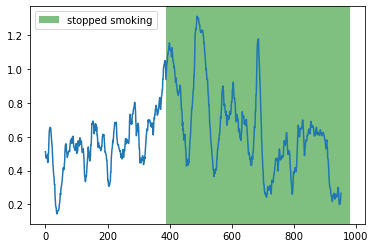

In [84]:
plt.plot(moving_avg(ses1.Alpha_TP10, 20))

plt.axvspan(387, 980, facecolor='green', alpha=0.5, label="stopped smoking")
plt.legend()
plt.show()

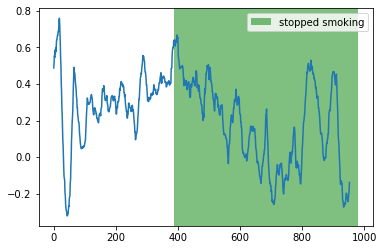

In [62]:
plt.plot(moving_avg(ses1.Alpha_AF7, 20))
plt.axvspan(387, 980, facecolor='green', alpha=0.5, label="stopped smoking")
plt.legend()
plt.show()

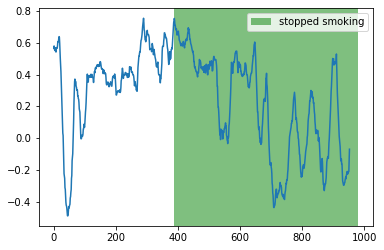

In [63]:
plt.plot(moving_avg(ses1.Alpha_AF8, 20))
plt.axvspan(387, 980, facecolor='green', alpha=0.5, label="stopped smoking")
plt.legend()
plt.show()

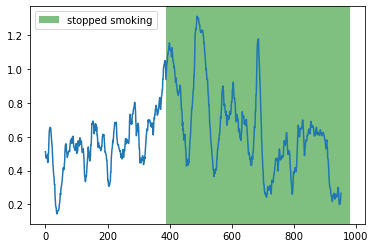

In [64]:
plt.plot(moving_avg(ses1.Alpha_TP10, 20))
plt.axvspan(387, 980, facecolor='green', alpha=0.5, label="stopped smoking")
plt.legend()
plt.show()

### Session Two

|time|action|
|-|-|
|0:00-6:36| normal breathing focusing on nothing|
|6:36-6:40| stressful thought|
|6:45-7:00| writing|
|8:45-9:15| focussed on clock|
|9:15-9:30| writing|
|9:30-10:25| normal breathing focusing on nothing|
|10:25| picked up vape and inhaled|
|10:45| picked up vape and inhaled (swallowed)|
|11:25| picked up vape and inhaled|
|11:45| picked up vape and inhaled (swallowed)|
|11:45-15:00| Continued to vape every minute until 15:00|
|15:00-20:00| normal breathing focusing on nothing|
|20:00| end writing|

|external variable| description|
|-|-|
|Setting| In my living room, sitting at my desk|
|Ambient noise| Birds chirping
|Vape used| Smok Novo X at 24watts|
|Salt Nicotine used|  50mg Apple by Reds|




In [48]:
# Lets focus of session two
ses2 = pd.read_csv(session_two_fp, parse_dates=["TimeStamp"])
init_timestamp = ses2.loc[0, "TimeStamp"] 

In [49]:
from datetime import timedelta

In [65]:
ses2

,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements
0,2021-02-24 07:21:48.185,0.965861,0.929035,0.772814,1.467185,0.668411,0.322398,0.420314,1.046369,1.140487,...,0.269532,-0.007813,0.968752,1.0,1.0,1.0,1.0,1.0,81.500000,NaN
1,2021-02-24 07:21:48.524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/muse/elements/blink
2,2021-02-24 07:21:48.672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/muse/elements/jaw_clench
3,2021-02-24 07:21:49.184,1.088368,0.698487,0.411292,1.167347,0.743914,-0.266490,-0.025824,1.204281,1.061789,...,-0.183594,0.062500,0.996095,1.0,1.0,1.0,1.0,1.0,81.500000,NaN
4,2021-02-24 07:21:50.185,0.693538,1.435450,0.373186,1.617076,0.886056,0.219446,-0.278131,0.416625,0.677910,...,-0.195313,0.058594,0.992189,1.0,1.0,1.0,1.0,1.0,81.500000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,2021-02-24 07:42:19.143,0.356143,-0.069989,-0.385208,0.396941,0.001212,-0.241234,-0.476406,0.746146,0.676658,...,0.171875,0.011719,0.988283,1.0,1.0,1.0,1.0,1.0,67.139999,NaN
1467,2021-02-24 07:42:20.143,0.365219,0.200207,0.404192,0.667214,0.519516,0.058566,0.065408,0.852510,1.119285,...,0.207032,0.125000,0.996095,1.0,1.0,1.0,1.0,1.0,67.139999,NaN
1468,2021-02-24 07:42:21.147,0.326561,0.173633,0.379947,0.379096,0.349987,0.016860,-0.105826,0.542793,1.108359,...,0.140625,0.125000,0.996095,1.0,1.0,1.0,1.0,1.0,67.139999,NaN
1469,2021-02-24 07:42:22.154,0.281360,0.010264,-0.277543,0.359201,0.073244,-0.469995,-0.434132,0.095313,0.737946,...,0.218750,0.105469,0.980470,1.0,1.0,1.0,1.0,1.0,67.139999,NaN


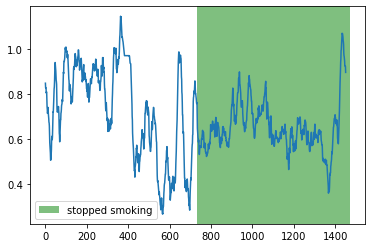

In [66]:
plt.plot(moving_avg(ses2.Alpha_TP10, 20))
plt.axvspan(733, 1470, facecolor='green', alpha=0.5, label="started smoking")
plt.legend()
plt.show()

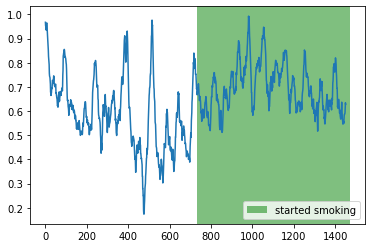

In [69]:
plt.plot(moving_avg(ses2.Alpha_TP9,20))
plt.axvspan(733, 1470, facecolor='green', alpha=0.5, label="started smoking")
plt.legend()
plt.show()

In [72]:
ses2.columns

Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7',
       'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8',
       'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10',
       'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'HeadBandOn',
       'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery', 'Elements'],
      dtype='object')

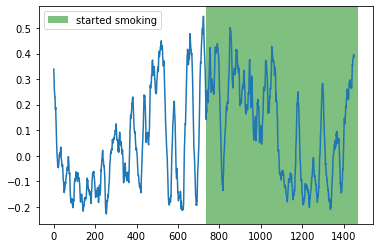

In [74]:
plt.plot(moving_avg(ses2.Alpha_AF8,20))
plt.axvspan(733, 1470, facecolor='green', alpha=0.5, label="started smoking")
plt.legend()
plt.show()

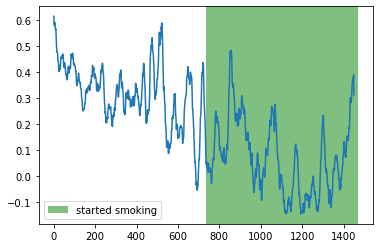

In [75]:
plt.plot(moving_avg(ses2.Alpha_AF7,20))
plt.axvspan(733, 1470, facecolor='green', alpha=0.5, label="started smoking")
plt.legend()
plt.show()

### Session Three

|time|action|
|-|-|
|12:18-12:21| no nic|
|12:21-12:24| nic|
|12:24-12:27| no nic|

|external variable| description|
|-|-|
|Setting| Sitting at a chair, minimal movement, consistent and similar intervals of breath|
|Vape| Puff Bar Liche Ice|

In [31]:
ses3 = pd.read_csv(session_three_fp, parse_dates=["TimeStamp"])